In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from datetime import datetime, timedelta
import subprocess

In [6]:
def read_file(filename):
    names, errors, shape = [], [], []
    with open(filename, 'r') as file:
        for line in file:
            # Split the line into its components using whitespace as the delimiter
            parts = line.strip().split()
            # Extract the "name", "val1", and "val2" from the parts list
            names.append(parts[0])
            errors.append(float(parts[1]))
            shape.append(float(parts[2]))
    return names, errors, shape


def time_difference_in_seconds(time_str1, time_str2):
    # Convert time strings to datetime objects
    time_format = "%Y/%m/%d-%H:%M:%S"
    time1 = datetime.strptime(time_str1, time_format)
    time2 = datetime.strptime(time_str2, time_format)

    return (time2 - time1).total_seconds()


def time_average(time_str1, time_str2):
    # Convert time strings to datetime objects
    time_format = "%Y/%m/%d-%H:%M:%S"
    time1 = datetime.strptime(time_str1, time_format)
    time2 = datetime.strptime(time_str2, time_format)

    time_difference = time2 - time1
    midpoint = time1 + (time_difference / 2)

    return midpoint


def getJobsPerMinuteNew(times, nJobs, spacing=5):
    xPos, height, width = [], [], []
    t_last, n_last = times[0], nJobs[0]
    for t, n in zip(times, nJobs):
        tDiff = time_difference_in_seconds(t_last, t)
        if tDiff >= 60*spacing:
            xPos.append(time_average(t_last, t))
            height.append((n-n_last)/tDiff*60.0)
            width.append(tDiff/(3600*24))
            t_last, n_last = t, n
    return xPos, height, np.asarray(width)


def getLastHourValues(times, nJobs, maxTime=60):
    hourTimes, hourJobs = [], []
    lastTime = times[-1]
    #print(lastTime)
    for t, n in zip(times[::-1], nJobs[::-1]):
        hourTimes.append(t)
        hourJobs.append(n)
        tDiff = time_difference_in_seconds(t, lastTime)
        #print(tDiff)
        if tDiff >= 60*maxTime:
            break
    return hourTimes[::-1], hourJobs[::-1]


1233


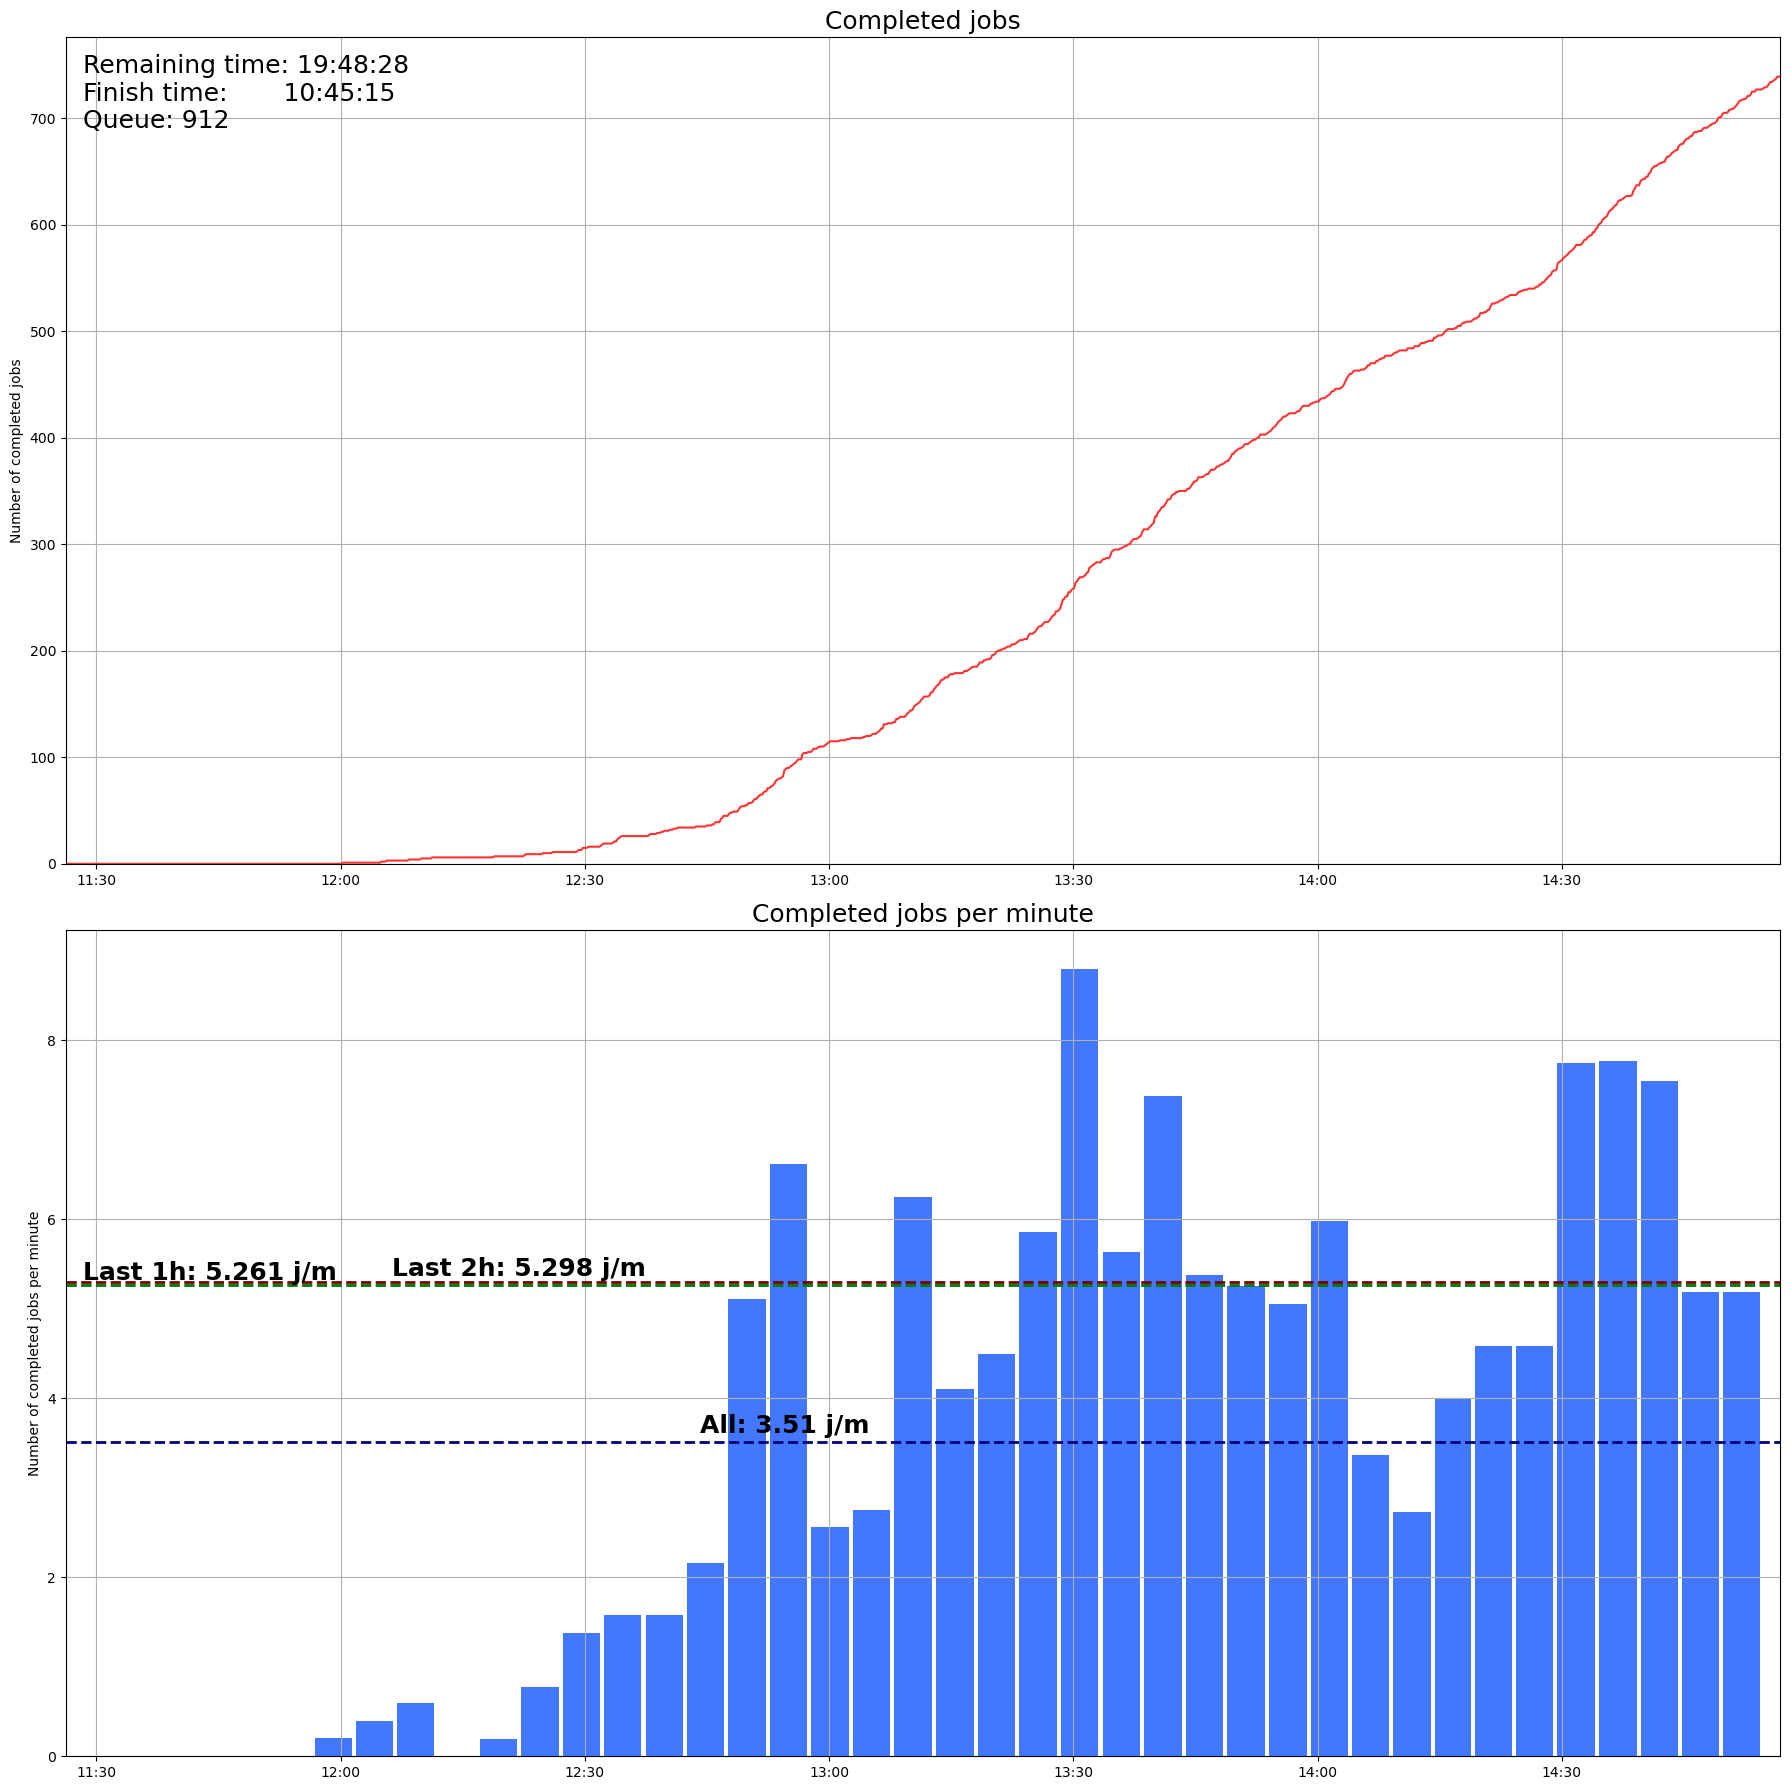

In [27]:
arrs = read_file("timeJobs.txt")
print(len(arrs[0]))
time_format = "%Y/%m/%d-%H:%M:%S"
# Calculate the regression line using scipy's linregress function
hourTimes, hourJobs = getLastHourValues(arrs[0], arrs[1])
#for t, n in zip(hourTimes, hourJobs):
#    print(t, n)
#slope, intercept, r_value, p_value, std_err = stats.linregress([datetime.strptime(t, time_format).hour*60 + datetime.strptime(t, time_format).minute for t in arrs[0][-360:]], arrs[1][-360:])
slope, intercept, r_value, p_value, std_err = stats.linregress([datetime.strptime(t, time_format).hour*60 + datetime.strptime(t, time_format).minute for t in hourTimes], hourJobs)

nTotJobs = 7200

remainingTime = "Remaining time: {}:{:02d}:{:02d}".format(int((nTotJobs - arrs[1][-1])/slope/60), int(((nTotJobs - arrs[1][-1])/slope)%60), int(((((nTotJobs - arrs[1][-1])/slope))%1)*60))
time_obj_seconds = timedelta(seconds=(nTotJobs - arrs[1][-1])/slope*60)
finish_datetime = datetime.strptime(arrs[0][-1], time_format) + time_obj_seconds
finishTime = "Finish time:       {}".format(finish_datetime.time().strftime("%H:%M:%S"))
queuedJobs = subprocess.run("squeue --me | wc -l", shell=True, capture_output=True, text=True).stdout

#print(remainingTime)
#print(finishTime)

time_format_axis = "%H:%M"
x_min = datetime.strptime(arrs[0][0], time_format)
x_max = datetime.strptime(arrs[0][-1], time_format)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 18))

ax1.plot([datetime.strptime(t, time_format) for t in arrs[0]], arrs[1], color="#ff3333")
ax1.annotate(remainingTime + "\n" + finishTime + "\n" + "Queue: " + str(queuedJobs), xy=(0.01, 0.98), xycoords='axes fraction', fontsize=18, horizontalalignment='left', verticalalignment='top')
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter(time_format_axis))
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(0)
ax1.set_ylabel('Number of completed jobs')
ax1.set_title('Completed jobs', fontsize=18)
ax1.grid()

corse=max((x_max-x_min).seconds//3600, 1)


#jobsPM = getJobsPerMinute(getJobsIntervals(arrs[1], n=n), getTimeIntervals(arrs[0], n=n))
#meanJPM = np.mean(jobsPM)
space = 5
if time_difference_in_seconds(arrs[0][0], arrs[0][-1])/60./60. > 5:#more than 5h, spacing every 10 mins
    space = 10
elif time_difference_in_seconds(arrs[0][0], arrs[0][-1])/60./60. > 10:#more than 10h, spacing every 15 mins
    space = 15
xPos, nJobsMin, width = getJobsPerMinuteNew(arrs[0], arrs[1], spacing=space)
#for x, y, z in zip(xPos, nJobsMin, width):
#    print(x, y, z*24*60)

meanJPM = (hourJobs[-1] - hourJobs[0])/(time_difference_in_seconds(hourTimes[0], hourTimes[-1])/60.)

twoHourTimes, twoHourJobs = getLastHourValues(arrs[0], arrs[1], maxTime=120)
meanJPM2hr = (twoHourJobs[-1] - twoHourJobs[0])/(time_difference_in_seconds(twoHourTimes[0], twoHourTimes[-1])/60.)
meanJPMAll = (arrs[1][-1] - arrs[1][0])/(time_difference_in_seconds(arrs[0][0], arrs[0][-1])/60.)


ax2.bar(xPos, nJobsMin, color="#4477ff", width=width-30/24/3600)
ax2.axhline(y=meanJPM, color='#007700', linestyle='--', linewidth=2)
ax2.annotate("Last 1h: {} j/m".format(round(meanJPM, 3)), xy=(0.01, meanJPM/np.max(nJobsMin) - 0.013), xycoords='axes fraction', fontsize=18, horizontalalignment='left', verticalalignment='center', weight="bold")
ax2.axhline(y=meanJPM2hr, color='#770000', linestyle='--', linewidth=2)
ax2.annotate("Last 2h: {} j/m".format(round(meanJPM2hr, 3)), xy=(0.19, meanJPM2hr/np.max(nJobsMin) - 0.013), xycoords='axes fraction', fontsize=18, horizontalalignment='left', verticalalignment='center', weight="bold")
ax2.axhline(y=meanJPMAll, color='#000077', linestyle='--', linewidth=2)
ax2.annotate("All: {} j/m".format(round(meanJPMAll, 3)), xy=(0.37, meanJPMAll/np.max(nJobsMin) - 0.00), xycoords='axes fraction', fontsize=18, horizontalalignment='left', verticalalignment='center', weight="bold")
ax2.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter(time_format_axis))
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(0)
ax2.set_ylabel('Number of completed jobs per minute')
ax2.set_title('Completed jobs per minute', fontsize=18)
ax2.grid()

plt.tight_layout()
plt.savefig('/home/submit/pdmonte/public_html/jobs.png')
plt.show()
